# Comparing model performances

Our objective is to evaluate the performance of the seq#-classifier on simulations created using a range of evolutionary models. For this, we generate figures depicting the learning curves of the pre-trained models. Furthermore, we employ various metrics and sanity checks to thoroughly validate the CNN's performance. In addition, we conduct multiple two-sample t-tests to investigate whether there are any significant differences in performance. This exploration helps us determine whether more complex evolutionary models result in simulations that are more realistic and consequently more challenging for the network to distinguish accurately.

In [1]:
# import relevant packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib
#%matplotlib notebook 
# or inline

from scipy.stats import ttest_ind
from scipy.stats.stats import pearsonr

from seqsharp.ConvNet import load_model
from seqsharp.plots import plot_folds
from seqsharp.train_eval import evaluate_folds, get_close_baccs

/var/folders/f8/v13bbmv53_z7q9w1_d8cgy780000gn/T/ipykernel_95324/2773676841.py:12: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


### Load pre-trained models
Multiple pre-trained seq#-models for DNA and protein sequences are available in the `pretrained_models` folder. These models can distinguish simulated and empirical multiple sequence alignments (MSAs). Each pre-trained seq#-model was trained on simulations based on a particular evolutionary model and includes CNNs for 10 splits of the data into validation and training data sets (k-fold cross validation). For more details on the pre-trained seq#-models 2 examples are printed below. 

In [2]:
# setup structure for different evo. model CNNs from simple to complex
models_dir = 'pretrained_models'
model_dirs = {'protein': ['prot_cnn_poisson', 'prot_cnn_wag', 'prot_cnn_lg',
                          'prot_cnn_lg_c60', 'prot_cnn_lg_s0256',
                          'prot_cnn_lg_s256_g4', 'prot_cnn_lg_s0256_gc',
                          'prot_cnn_lg_s0256_gc_sparta'],
              'dna': ['dna_cnn_jc', 'dna_cnn_hky', 'dna_cnn_gtr',
                      'dna_cnn_gtr_g', 'dna_cnn_gtr_g_i',
                      'dna_cnn_gtr_g_i_mimick', 'dna_cnn_gtr_g_i_sparta']}
evo_models = {'protein': ['Poisson', 'WAG', 'LG', 'LG+C60', 'LG+S256',
                          'LG+S256+G4', 'LG+S256+GC', 'LG+S256+GC+Indels'],
              'dna': ['JC', 'HKY', 'GTR', 'GTR+G', 'GTR+G+I', 'GTR+G+I+mimick',
                      'GTR+G+I+sparta']}
mol_types = ['dna', 'protein']

# setup data structure
models = {'protein': {}, 
          'dna': {}}

# load models
for mol_type in mol_types:
    for i, (dirname, name) in enumerate(zip(model_dirs[mol_type],
                                            evo_models[mol_type])):
        models[mol_type][name] = load_model(os.path.join(models_dir, dirname))

In [3]:
# Example of a DNA model
print(models['dna']['GTR+G'][0])  # fold 1 

ConvNet(
  (conv_layers): Sequential(
    (0): Conv1d(5, 100, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(100, 210, kernel_size=(1,), stride=(1,))
    (3): ReLU()
    (4): AvgPool1d(kernel_size=(9930,), stride=(9930,), padding=(0,))
    (5): Dropout(p=0.2, inplace=False)
  )
  (lin_layers): Sequential(
    (0): Linear(in_features=210, out_features=1, bias=True)
  )
)


In [4]:
# Example of a protein model
print(models['protein']['LG'][9])  # fold 10

ConvNet(
  (conv_layers): Sequential(
    (0): Conv1d(21, 210, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(1479,), stride=(1479,), padding=(0,))
    (3): Dropout(p=0.2, inplace=False)
  )
  (lin_layers): Sequential(
    (0): Linear(in_features=210, out_features=1, bias=True)
  )
)


## Learning curves

Learning curves show the model performance on training and validation data over epochs. Here, we show the balanced accuracy score (1st and 3rd column in figure below) and the loss (2nd and 4th column in figure below).  The top figure shows seq#-models for DNA data and the bottom figure seq#-models for protein data. For each evo. model the learning curves of seq#-models of all 10 folds are stacked in one plot. The complexity of evo. models increases from left to right and top to bottom.

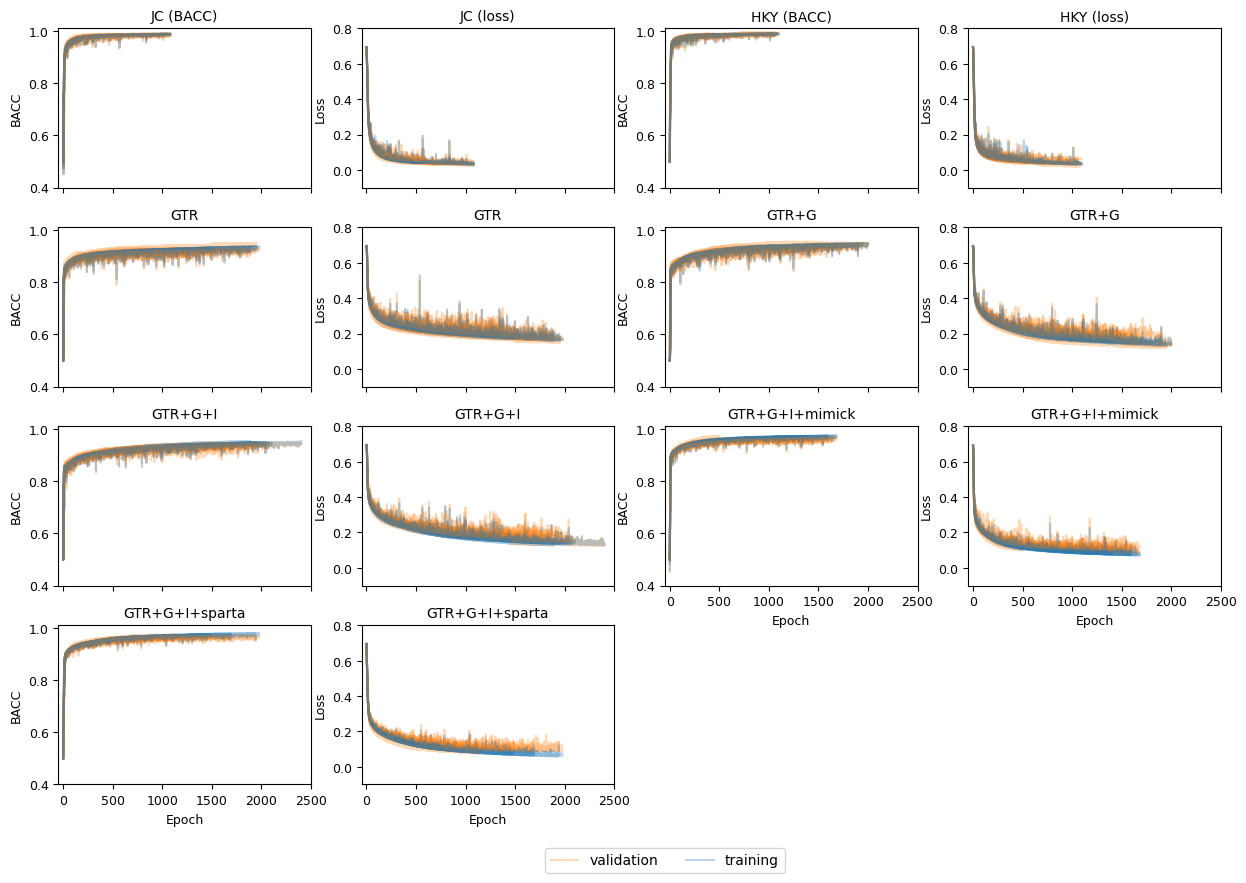

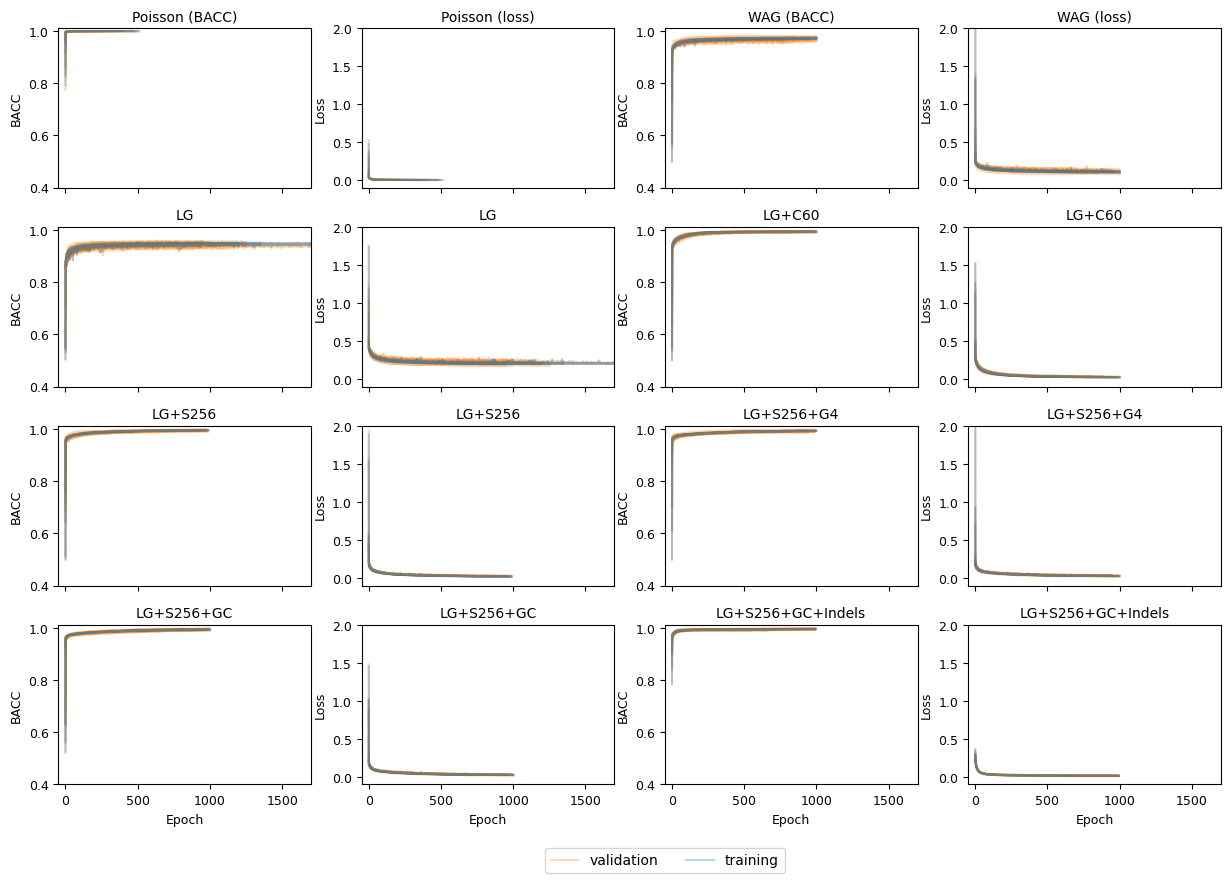

In [5]:
# Learning curves of DNA and protein models

ylims = {'dna': (-0.1, 0.8), 'protein': (-0.1, 2)}
xlims = {'dna': (-50, 2500), 'protein': (-50, 1700)}
plot_shape = (4, 4)

for mol_type in mol_types:

    fig, axs = plt.subplots(*plot_shape, figsize=[15, 12])

    for i, evo_model in enumerate(evo_models[mol_type]):

        # get axis
        r1, c1 = np.unravel_index(i * 2, plot_shape)
        r2, c2 = np.unravel_index(i * 2 + 1, plot_shape)
        ax1, ax2 = axs[r1, c1], axs[r2, c2]

        plot_folds(models[mol_type][evo_model], axs=[ax1, ax2])

        # set axis limits
        ax1.set_ylim(0.4, 1.01)
        ax2.set_ylim(*ylims[mol_type])
        ax1.set_xlim(*xlims[mol_type])
        ax2.set_xlim(*xlims[mol_type])

        # display evo. Model and eventually performance metric
        if i < 2:
            ax1.set_title(f'{evo_model} (BACC)', fontsize=10)
            ax2.set_title(f'{evo_model} (loss)', fontsize=10)
        else:
            ax1.set_title(f'{evo_model}', fontsize=10)
            ax2.set_title(f'{evo_model}', fontsize=10)

        # display x-ticks and labels of last row only
        if i >= len(evo_models[mol_type]) - 2:
            ax1.set_xlabel('Epoch', fontsize=9)
            ax2.set_xlabel('Epoch', fontsize=9)
        else:
            ax1.set_xlabel('')
            ax2.set_xlabel('')
            ax1.set_xticklabels([])
            ax2.set_xticklabels([])

        ax1.set_ylabel('BACC', fontsize=9)
        ax2.set_ylabel('Loss', fontsize=9)
        ax1.tick_params(axis='both', labelsize=9)
        ax2.tick_params(axis='both', labelsize=9)

        handles, labels = ax1.get_legend_handles_labels()

    # do not display empty plots for DNA models (bottom left)
    if mol_type == 'dna':
        i = len(model_dirs['dna'])
        r1, c1 = np.unravel_index(i * 2, plot_shape)
        r2, c2 = np.unravel_index(i * 2 + 1, plot_shape)
        axs[r1, c1].axis('off')
        axs[r2, c2].axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.25)
    plt.legend(handles, labels,
               bbox_to_anchor=[-1.2, -0.6], loc='lower center', ncol=2)

    plt.show()

## Performance of pre-trained seq#-models
### Different metrics and sanity checks

In the following, we analyze several metrics and perform sanity checks to assess the performance of the CNN for the given evolutionary model. These metrics include:

- Mean Balanced Accuracy (BACC) across folds: We calculate the average BACC value across different folds to assess the overall performance of the model.

- Standard Error (SE): We employ the SE to evaluate the probability of the mean BACC accurately representing the true BACC for the CNN and the evolutionary model.

- Mean, minimum, and maximum BACCs of epochs surrounding the epoch with the highest BACC (referred to as n-BACC): By considering the BACC values of neighboring epochs, we can determine the range of performance and identify any potential variations in accuracy.

- Accuracy per class: We examine the accuracy of individual classes to gain insights into the model's performance on each specific category.

- Mean Absolute Error (MAE) of the two classes: The MAE aids in assessing whether the accuracy of any individual class is influencing the balanced accuracy score, helping to identify potential biases.

By analyzing these metrics and conducting sanity checks, we can comprehensively evaluate the performance of the CNN under the given evolutionary model.

In [6]:
# init dict for different performance metrics
tables = {'dna': {'Evo. Model': [], 'BACC': [], 'SE': [], 
                  'AVG n-BACC': [], 'MIN n-BACC': [], 'MAX n-BACC': [], 
                  'ACC SIM': [], 'ACC EMP': [], 'Class MAE': []}, 
          'protein': {'Evo. Model': [], 'BACC': [], 'SE': [], 
                      'AVG n-BACC': [], 'MIN n-BACC': [], 'MAX n-BACC': [], 
                      'ACC SIM': [], 'ACC EMP': [], 'Class MAE': []}}
# init dict for BACCs of individual folds
models_baccs = {'dna': {}, 'protein': {}}

for mol_type in mol_types:
    for i, (dirname, name) in enumerate(zip(model_dirs[mol_type],
                                            evo_models[mol_type])):
        
        # validation history of all models
        val_hist_folds = [m.val_history for m in models[mol_type][name]]
        # determine best epoch according to validation BACC
        val_folds, best_epochs = evaluate_folds(val_hist_folds, 
                                                len(models[mol_type][name]))
        
        # extract BACC and class accuracy for all models
        baccs = [x['bacc'] for x in val_hist_folds]
        emp_accs = [x['acc_emp'] for x in val_hist_folds]
        sim_accs = [x['acc_sim'] for x in val_hist_folds]        
        
        # ----- Fill table
        
        tables[mol_type]['Evo. Model'].append(name)

        # avg. BACC and SE over folds at selected epoch
        best_baccs = [bacc[best] for bacc, best in zip(baccs, best_epochs)]
        tables[mol_type]['BACC'].append(np.mean(best_baccs))
        tables[mol_type]['SE'].append(np.std(best_baccs) / np.sqrt(len(best_baccs)))
        
        models_baccs[mol_type][name] = best_baccs
        
        # summarize BACCs of epochs surrounding the selected epoch
        close_epochs = get_close_baccs(baccs, best_epochs)
        tables[mol_type]['AVG n-BACC'].append(np.mean(close_epochs))
        tables[mol_type]['MIN n-BACC'].append(np.min(close_epochs))
        tables[mol_type]['MAX n-BACC'].append(np.max(close_epochs))
        
        # avg. class accuracy over folds and mean abs. error of classes
        best_emp_accs = [acc[best] for acc, best in
                         zip(emp_accs, best_epochs)]
        best_sim_accs = [acc[best] for acc, best in
                         zip(sim_accs, best_epochs)]
        best_emp_accs = np.asarray(best_emp_accs)
        best_sim_accs = np.asarray(best_sim_accs)
        tables[mol_type]['ACC SIM'].append(np.mean(best_sim_accs))
        tables[mol_type]['ACC EMP'].append(np.mean(best_emp_accs))
        tables[mol_type]['Class MAE'].append(np.mean(np.abs(best_emp_accs -
                                                        best_sim_accs)))

###  DNA models

In [7]:
display(pd.DataFrame(tables['dna']))

avg_all_baccs = np.mean(np.mean(np.asarray(list(models_baccs['dna'].values())),
                                    axis=1)).round(2)
print(f'\nAVG BACC across Evo. Models: {avg_all_baccs}')

,Evo. Model,BACC,SE,AVG n-BACC,MIN n-BACC,MAX n-BACC,ACC SIM,ACC EMP,Class MAE
0,JC,0.987349,0.000690,0.984098,0.983494,0.985108,0.990561,0.984138,0.006685
1,HKY,0.990672,0.000732,0.987815,0.986753,0.988845,0.990564,0.990781,0.005124
2,GTR,0.930266,0.002668,0.923508,0.920761,0.926004,0.943769,0.916763,0.027006
3,GTR+G,0.942656,0.002835,0.934837,0.931236,0.936852,0.949987,0.935325,0.018024
4,GTR+G+I,0.941976,0.002206,0.934331,0.932730,0.936111,0.949433,0.934518,0.020214
5,GTR+G+I+mimick,0.968564,0.000963,0.962514,0.960157,0.964088,0.969413,0.967714,0.007027
6,GTR+G+I+sparta,0.970280,0.001505,0.963688,0.960161,0.966138,0.976071,0.964488,0.011963



AVG BACC across Evo. Models: 0.96


### Protein models

In [8]:
display(pd.DataFrame(tables['protein']))

avg_all_baccs = np.mean(np.mean(np.asarray(list(models_baccs['protein'].values())),
                                    axis=1)).round(2)
print(f'\nAVG BACC across Evo. Models: {avg_all_baccs}')

,Evo. Model,BACC,SE,AVG n-BACC,MIN n-BACC,MAX n-BACC,ACC SIM,ACC EMP,Class MAE
0,Poisson,0.999641,0.000152,0.998966,0.998709,0.999354,0.999857,0.999426,0.000717
1,WAG,0.973604,0.001638,0.969865,0.969229,0.971024,0.975327,0.971882,0.012050
2,LG,0.950653,0.001811,0.943897,0.941975,0.944769,0.952230,0.949076,0.015222
3,LG+C60,0.994190,0.000532,0.992158,0.991680,0.992469,0.995410,0.992971,0.003588
4,LG+S256,0.995194,0.000601,0.993772,0.993473,0.994047,0.996127,0.994262,0.002438
5,LG+S256+G4,0.993042,0.000718,0.991351,0.991106,0.991679,0.993688,0.992397,0.003872
6,LG+S256+GC,0.993832,0.000825,0.992493,0.992038,0.993186,0.996844,0.990819,0.006312
7,LG+S256+GC+Indels,0.995899,0.000408,0.994645,0.994460,0.994891,0.997266,0.994532,0.003597



AVG BACC across Evo. Models: 0.99


## Significance of mean BACC differences
Here, we conduct multiple unpaired two-sample t-tests to determine whether different evolutionary models yield significantly different mean Balanced Accuracy (BACC) values. Our focus was to assess whether more complex evolutionary models, which are expected to generate more realistic simulations, result in lower BACC scores.
We apply Bonferroni correction to the p-values, while assuming a significance cutoff of 0.05.

### DNA models

In [9]:
np.random.seed(42)

test_models = np.asarray(evo_models['dna'])

# determine test group indices
group1 = np.arange(len(test_models) - 1).astype(int)
group2 = np.arange(1, len(test_models)).astype(int)

# contuct multiple unpaired two-sample t-tests
pvals = {}
for i, j in zip(group1, group2):
    pvals[f'{test_models[i]}, {test_models[j]}'] = ttest_ind(
        models_baccs['dna'][test_models[i]],
        models_baccs['dna'][test_models[j]]).pvalue
pvals.pop('GTR+G+I, GTR+G+I+mimick')

# bonferroni correction
n_tests = len(list(pvals.values()))
for gr, pval in pvals.items():
    pvals[gr] = pval * n_tests
    
pvals_df = pd.DataFrame(pvals, index=['p-value'])

display(pvals_df)

,"JC, HKY","HKY, GTR","GTR, GTR+G","GTR+G, GTR+G+I","GTR+G+I+mimick, GTR+G+I+sparta"
p-value,0.028661,2.624295e-13,0.036848,4.297011,1.871871


### Protein models

In [15]:
np.random.seed(42)

test_models = np.asarray(evo_models['protein'])

# determine test group indices
group1, group2 = np.triu_indices(4, 1)
group1, group2 = group1 + 3, group2 + 3
group1 = np.concatenate(([0, 1, 2], group1), dtype=int)
group2 = np.concatenate(([1, 2, 3], group2), dtype=int)

# conduct multiple unpaired two-sample t-tests
pvals = {}
for i, j in zip(group1, group2):
    pvals[f'{test_models[i]}, {test_models[j]}'] = ttest_ind(
        models_baccs['protein'][test_models[i]],
        models_baccs['protein'][test_models[j]]).pvalue

print(pvals)

# bonferroni correction
n_tests = len(list(pvals.values()))

print(n_tests)

for gr, pval in pvals.items():
    pvals[gr] = pval * n_tests

pvals_df = pd.DataFrame(pvals, index=['p-value'])

display(pvals_df)

{'Poisson, WAG': 1.269877879575484e-11, 'WAG, LG': 5.0499353557205653e-08, 'LG, LG+C60': 2.0173882489697217e-14, 'LG+C60, LG+S256': 0.2503553748301361, 'LG+C60, LG+S256+G4': 0.2386511852747311, 'LG+C60, LG+S256+GC': 0.7331231445900153, 'LG+S256, LG+S256+G4': 0.042708041754426725, 'LG+S256, LG+S256+GC': 0.22153160615574088, 'LG+S256+G4, LG+S256+GC': 0.5023670471407556}
9


,"Poisson, WAG","WAG, LG","LG, LG+C60","LG+C60, LG+S256","LG+C60, LG+S256+G4","LG+C60, LG+S256+GC","LG+S256, LG+S256+G4","LG+S256, LG+S256+GC","LG+S256+G4, LG+S256+GC"
p-value,1.142890e-10,4.544942e-07,1.815649e-13,2.253198,2.147861,6.598108,0.384372,1.993784,4.521303


# Logistic regression on MSA-compositions vs. CNN on site-compositions
Since the CNN is performing very accuractely using global average pooling and a kernel size of one we suspect that there are underlying global features the CNN exploits for the discrimination. 
Therefore, we investigate if there is a mismatch between simulated and empirical average MSA compositions. To this end, we trained logistic regression model to learn the classification on protein MSA compositions.
Here, we compare the BACCs of the pre-trained CNN and logistic regression models.

In [11]:
# setup data structures for seq#-models performances
model_ids = ['cnn', 'logreg']
model_dirs = {'cnn': ['prot_cnn_poisson', 'prot_cnn_wag', 'prot_cnn_lg',
                      'prot_cnn_lg_c60', 'prot_cnn_lg_s0256',
                      'prot_cnn_lg_s256_g4', 'prot_cnn_lg_s0256_gc',
                      'prot_cnn_lg_s0256_gc_sparta'],
              'logreg': ['prot_logreg_poisson', 'prot_logreg_wag', 'prot_logreg_lg',
                         'prot_logreg_lg_c60', 'prot_logreg_lg_s0256',
                         'prot_logreg_lg_s256_g4', 'prot_logreg_lg_s0256_gc',
                         'prot_logreg_lg_s0256_gc_sparta'] }
model_types = ['CNN', 'Logistic Regression']
perfrmncs_dict = {'Model Type': [], 'Evo. Model': [], 'Fold': [], 'BACC': []}

# load BACCs and meta infos 
for m_id, m_type in zip(model_ids, model_types):
    for i, (dirname, name) in enumerate(zip(model_dirs[m_id],
                                            evo_models['protein'])):
        
        models = load_model(os.path.join(models_dir, dirname))

        val_hist_folds = [m.val_history for m in models]
        val_folds, best_epochs = evaluate_folds(val_hist_folds, len(models))

        baccs = [x['bacc'] for x in val_hist_folds]
        best_baccs = [bacc[best] for bacc, best in zip(baccs, best_epochs)]
        n_folds = len(best_baccs)
        perfrmncs_dict['Model Type'] += [m_type] * n_folds
        perfrmncs_dict['Evo. Model'] += [name] * n_folds
        perfrmncs_dict['Fold'] += list(range(1, n_folds + 1))
        perfrmncs_dict['BACC'] += best_baccs
perfrmncs_df = pd.DataFrame(perfrmncs_dict)

After collecting all the necessary information from the trained models, we plot their performances.
In the following figure, the x-axis shows the evolutionary models from simple (left) to complex (right) and the BACC on the y-axis. Plotted are the average BACCs of all folds (non-transparent points) and the BACCs of the individual folds (transparent points) and their error bars. 

Overall, the logistic regression models achieve BACCs > 0.8 and are less accurate than the CNN models. They follow the same trend as the CNN models: for the first three models of site-homogeneous evolution, the accuracy decreases gradually. Once site-heterogeneous mixture models are in play, even the logistic regression models have no difficulty distinguishing the simulated and empirical data. With the 256-profile model (S256), the BACCs are even close to 0.95. 

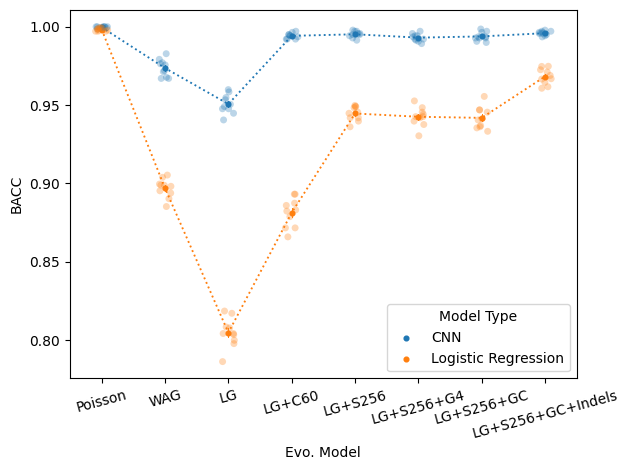

In [12]:
# plot BACCS  
# plt.figure(figsize=(8, 6.5))
plt.xticks(rotation=15)
sns.stripplot(data=perfrmncs_df, x='Evo. Model', y='BACC', hue='Model Type',
              alpha=0.3, legend=False)
sns.pointplot(data=perfrmncs_df, x='Evo. Model', y='BACC', hue='Model Type',
              errorbar='se', linestyles='dotted', scale = 0.5, errwidth=0.7)
plt.tight_layout()

Moreover, we find a correlation between the BACCs of CNNs and logistic regression models (r=0.85). 

PearsonRResult(statistic=0.8519699923066639, pvalue=1.2688601049205501e-23)

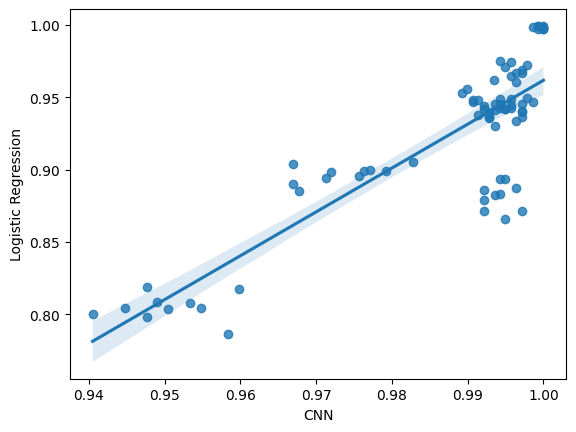

In [13]:
df_wide = pd.pivot(perfrmncs_df, index=['Evo. Model', 'Fold'],
                   columns='Model Type', values='BACC')
sns.regplot(x=df_wide['CNN'], y=df_wide['Logistic Regression'])
pearsonr(perfrmncs_df[perfrmncs_df['Model Type'] == 'CNN']['BACC'],
         perfrmncs_df[perfrmncs_df['Model Type'] == 'Logistic Regression']['BACC'])